# Prepare stock market data

## Task 1. a

### 1. Find all stock csv files (incorrectly labelled as txt)

In [2]:
import glob

base_path = './stock-market/Data/Stocks'
paths = []

for file in glob.glob(base_path + '/*.txt'):
    paths.append(file)

paths[:5]

['./stock-market/Data/Stocks/sdrl.us.txt',
 './stock-market/Data/Stocks/esge.us.txt',
 './stock-market/Data/Stocks/jobs.us.txt',
 './stock-market/Data/Stocks/pacb.us.txt',
 './stock-market/Data/Stocks/iac.us.txt']

### 2. Create dataframe while removing empty files

In [ ]:
import pandas as pd

df_list = []
empty_file_symbols = []

count = 0
for path in paths:
    count += 1
    symbol = path.split('/')[-1].split('.')[0]

    # Attempt to read the stock data
    try:
        # Temp
        if count % 5 == 0:
            stock_df = pd.read_csv(path)
            stock_df['Symbol'] = symbol
            df_list.append(stock_df)

    # If stock data is invalid or doens't exist, ignore
    except:
        empty_file_symbols.append(symbol)

df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Symbol'] = df['Symbol'].astype('string')

df.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Symbol
0,2005-08-25,5.5182,5.5182,5.5182,5.5182,16962,0,sdrl
1,2005-09-01,6.1761,6.1761,6.1761,6.1761,1698,0,sdrl
2,2005-09-02,6.0700,6.1761,6.0347,6.0700,18727,0,sdrl
3,2005-09-06,5.9286,6.0700,5.7517,5.9286,55410,0,sdrl
4,2005-09-07,5.8224,6.1054,5.7517,5.8224,47212,0,sdrl


### 3. Show column data types

In [4]:
print('Data types of columns:')
print(df.dtypes)

Data types of columns:
Date       datetime64[ns]
Open              float64
High              float64
Low               float64
Close             float64
Volume              int64
OpenInt             int64
Symbol     string[python]
dtype: object


### 4. Summary statistics

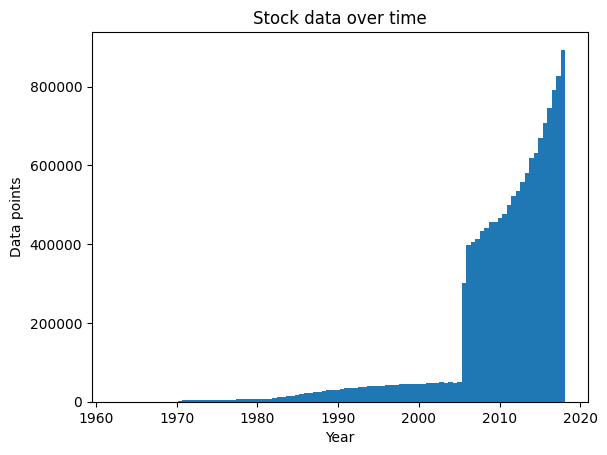

In [ ]:
import matplotlib.pyplot as plt

plt.hist(data=df, x='Date', bins=100)
plt.title('Stock data over time')
plt.xlabel('Year')
plt.ylabel('Data points')
plt.show()

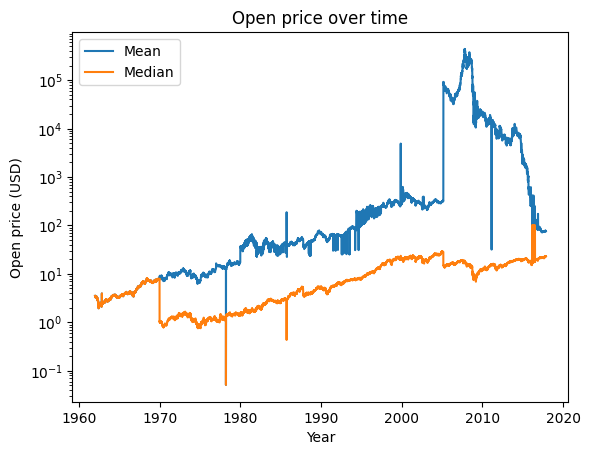

In [ ]:
date_data = df.groupby('Date')
dates = date_data.indices.keys()

plt.plot(dates, date_data['Open'].mean(), label='Mean')
plt.plot(dates, date_data['Open'].median(), label='Median')
plt.title('Open price over time')
plt.xlabel('Year')
plt.ylabel('Open price (USD)')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

## Task 1. b

### 1. Find missing values

In [8]:
print('Missing values in data:')
print(df.isna().sum())

print('\nStock symbols with empty files:')
print(len(empty_file_symbols), '-', empty_file_symbols)

Missing values in data:
Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
Symbol     0
dtype: int64

Stock symbols with empty files:
32 - ['vist', 'bolt', 'ehr', 'rbio', 'pbio', 'sfix', 'boxl', 'asns', 'accp', 'bxg', 'amrhw', 'sail', 'amrh', 'stnl', 'scci', 'vmet', 'pxus', 'hayu', 'send', 'mapi', 'srva', 'bbrx', 'znwaa', 'sbt', 'wnfm', 'fmax', 'molc', 'wspt', 'gnst', 'scph', 'jt', 'otg']


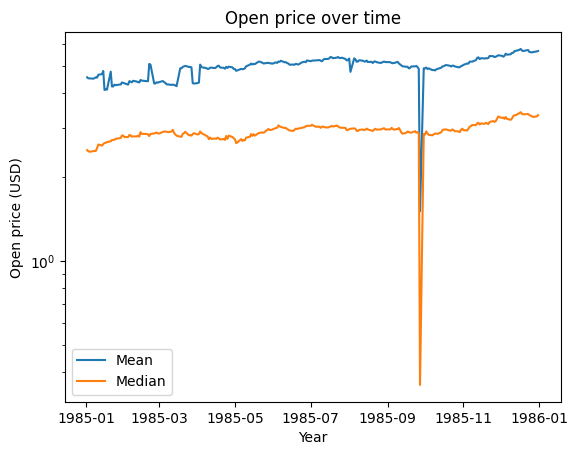

In [69]:
import datetime as dt

df = df[(df['Open'] < 100)]

date_data = df[(df['Date'] > dt.datetime(1985, 1, 1)) & (df['Date'] < dt.datetime(1986, 1, 1))].groupby('Date')
dates = date_data.indices.keys()

plt.plot(dates, date_data['Open'].mean(), label='Mean')
plt.plot(dates, date_data['Open'].median(), label='Median')
plt.title('Open price over time')
plt.xlabel('Year')
plt.ylabel('Open price (USD)')
plt.yscale('log')
plt.legend()
plt.show()